# Neural Network w/ backpropagation in Python from scratch

Lecture: https://www.youtube.com/watch?v=59Hbtz7XgjM
Post: https://cs231n.github.io/optimization-2/
Post: https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
Video: https://www.youtube.com/watch?v=4shguqlkTDM
Code Inspiration: https://github.com/yacineMahdid/artificial-intelligence-and-machine-learning/blob/master/deep-learning-from-scratch-python/multi_layer_perceptron.ipynb (different data, try out different activations - sigmoid, ReLu, tanh)
Code Inspiration 2: https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/

### Functional Implementation

In [54]:
import numpy as np
from csv import reader
import matplotlib.pyplot as plt

In [2]:
train = [[2.7810836,2.550537003, 0],
           [1.465489372,2.362125076, 0],
           [3.396561688,4.400293529, 0],
           [1.38807019,1.850220317, 0],
           [3.06407232,3.005305973, 0],
           [7.627531214,2.759262235, 1],
           [5.332441248,2.088626775, 1],
           [6.922596716,1.77106367, 1],
           [8.675418651,-0.242068655, 1],
           [7.673756466,3.508563011, 1]]

In [3]:
# 1. Initialize network with weights

n_hidden = 1 # number of hidden layers
n_inputs = len(train[0][:-1]) # number of features
n_hidden_neurons = [1, 1] # number of neurons in hidden layer
n_outputs = 2 # number of possible outputs to be predicted

def init_network(n_inputs, n_hidden, n_hidden_neurons, n_outputs):

    network = []
    
    # number of parameters = 1 per input (features in original data) + bias = n_inputs + 1
    # number of neurons in layer = n_hidden_neurons[i]
    i = 0
    for n in range(n_hidden):
        if i == 0:
            hidden_layer = [{'params': [np.random.rand() for n in range(n_inputs + 1)]} for n in range(n_hidden_neurons[i])]
        else:
            hidden_layer = [{'params': [np.random.rand() for n in range(n_hidden_neurons[i-1] + 1)]} for n in range(n_hidden_neurons[i])]
        network.append(hidden_layer)
        i += 1
        
    # number of parameters = 1 per input (neurons in previous hidden layer) + bias = n_hidden + 1
    # number of neurons in layer = n_outputs
    output_layer = [{'params': [np.random.rand() for n in range(n_hidden_neurons[i-1] + 1)]} for n in range(n_outputs)]
    network.append(output_layer)
    
    return network

def print_layers(network):
    i = 0
    for layer in network:
        if i < n_hidden:
            print(f'HIDDEN LAYER {i+1}')
            print(layer)
            print(' ')
        if i == n_hidden:
            print('OUTPUT LAYER')
            print(layer)
        i += 1
        
network = init_network(n_inputs, n_hidden, n_hidden_neurons, n_outputs)

print_layers(network)

HIDDEN LAYER 1
[{'params': [0.3487237855044789, 0.7648486226743969, 0.6608580080242392]}]
 
OUTPUT LAYER
[{'params': [0.7922861004551691, 0.9822940165221843]}, {'params': [0.8784281732681254, 0.648025418417123]}]


In [4]:
# Activation functions
def sigmoid(output):
    return 1.0 / (1.0 + np.exp(-output))

def ReLu(output):
    return max(0, output)

def tanh(output):
    return (np.exp(output)-np.exp(-output))/(np.exp(output)+np.exp(-output))

activation_functions = ('sigmoid', 'ReLu', 'tanh')

In [5]:
# 2. Forward propagate

# Calculates the output of a single neuron -> (weights * inputs) + bias
def calc_neuron_output(params, inputs):
    bias = params[-1]
    output = bias
    for i in range(len(params) - 1): # for every weight
        output += params[i] * inputs[i]
    return output

def forward_propagate(network, inputs):
    
    for layer in network:
        
        # this list will store the activated output of each neuron to be the input of the next layer
        # (in case the current layer is a hidden layer). Otherwise, this list will represent the outputs of the model
        next_inputs = []
        
        for neuron in layer:
            neuron_out = calc_neuron_output(neuron['params'], inputs) # linear output of neuron
            neuron['output_activated'] = sigmoid(neuron_out) # sigmoid activation of linear output
            next_inputs.append(neuron['output_activated'])
            
        inputs = next_inputs

    return inputs # outputs of output layer

forward_propagate(network, train[0][:-1])

[0.8523464088490081, 0.817971577265889]

In [6]:
# Derivatives of activation functions
def d_sigmoid(s):
    return s*(1-s)

def d_ReLu(r):
    return 1 if r > 0 else 0

def d_tanh(t):
    return 1-t**2

In [7]:
print_layers(network)

HIDDEN LAYER 1
[{'params': [0.3487237855044789, 0.7648486226743969, 0.6608580080242392], 'output_activated': 0.9729188489380506}]
 
OUTPUT LAYER
[{'params': [0.7922861004551691, 0.9822940165221843], 'output_activated': 0.8523464088490081}, {'params': [0.8784281732681254, 0.648025418417123], 'output_activated': 0.817971577265889}]


In [8]:
# 3. Back propagate error

# delta (error) for neuron in output layer = (y_pred-y_expected) * d_actv
# delta (error) for neuron in hidden layers = sum(all connected weights from top layer * corresponding delta)

# i is the ith layer of the network we are iterating through
# expected_output are the expected outputs of the network (neurons in the output layer)
##([1,0] for 0 , [0,1] for 1) (answer corresponds to the index where 1 is)

def backpropagate(network, i, expected_output):
    
    # Base case -- backpropagation starts in output layer
    if i == n_hidden:

        for n in range(len(network[i])): # loop through each neuron in the layer i of the network (output layer)
            neuron = network[i][n] # current neuron
            error = neuron['output_activated'] - expected_output[n] # error for output in neuron n of output layer
            neuron['delta'] = error * d_sigmoid(neuron['output_activated'])
        return
    # End of base case

    errors = backpropagate(network, i + 1, expected_output)
    
    for n in range(len(network[i])): # loop through each neuron in the layer i of the network (hidden layer)
        neuron = network[i][n] # current neuron
        error = 0.0
        for top_neuron in network[i+1]: # for each neuron in layer above
            # (weights of top layer that the neuron output was multiplied by) * (corresponding delta)
            error += top_neuron['params'][n] * top_neuron['delta']
        neuron['delta'] = error * d_sigmoid(neuron['output_activated'])
        
    return
            
backpropagate(network, 0, [1,0])

In [9]:
print_layers(network)

HIDDEN LAYER 1
[{'params': [0.3487237855044789, 0.7648486226743969, 0.6608580080242392], 'output_activated': 0.9729188489380506, 'delta': 0.002430899771229981}]
 
OUTPUT LAYER
[{'params': [0.7922861004551691, 0.9822940165221843], 'output_activated': 0.8523464088490081, 'delta': -0.018582500960042773}, {'params': [0.8784281732681254, 0.648025418417123], 'output_activated': 0.817971577265889, 'delta': 0.1217911222330187}]


In [10]:
# 4. Train network

def update_weights(network, row, lr):
    for i in range(len(network)): # for every layer in the network
        inputs = row[:-1] # take training inputs
        if i != 0: # for all layers except the first
            inputs = [neuron['output_activated'] for neuron in network[i-1]] # inputs are the output of the previous layer
        for neuron in network[i]: # for every neuron in the layer
            for j in range(len(inputs)): # for every input to the layer (every weight in the neuron)
                neuron['params'][j] -= lr * neuron['delta'] * inputs[j] # weight update
            neuron['params'][-1] -= lr * neuron['delta'] # bias update

def train_network(network, training_data, lr, n_epochs):
    
    for n_epoch in range(n_epochs):
        sse = 0.0
        
        for row in training_data:
            output = forward_propagate(network, row)
            expected = [0 for i in range(len(output))] # initialize to an array of 0s of same size as outputs
            expected[row[-1]] = 1 # if actual output is 1, expected is [0,1], if 0 it is [1,0]
            sse += sum([(expected[i]-output[i])**2 for i in range(len(expected))])
            backpropagate(network, 0, expected)
            update_weights(network, row, lr)
        
        if n_epoch % 10 == 0:
            print('>epoch=%d, error=%.3f' % (n_epoch, sse)) 

In [11]:
def backprop(training_data, lr, n_epochs, n_inputs, n_hidden, n_hidden_neurons, n_outputs):
    model = init_network(n_inputs, n_hidden, n_hidden_neurons, n_outputs)
    train_network(model, training_data, lr, n_epochs)
    
    return model
    
lr = 0.2
training_data = train
n_epochs = 500

model = backprop(training_data, lr, n_epochs, n_inputs, n_hidden, n_hidden_neurons, n_outputs)

>epoch=0, error=5.480
>epoch=10, error=5.124
>epoch=20, error=5.117
>epoch=30, error=5.116
>epoch=40, error=5.114
>epoch=50, error=5.113
>epoch=60, error=5.111
>epoch=70, error=5.109
>epoch=80, error=5.106
>epoch=90, error=5.101
>epoch=100, error=5.094
>epoch=110, error=5.081
>epoch=120, error=5.051
>epoch=130, error=4.935
>epoch=140, error=4.308
>epoch=150, error=3.195
>epoch=160, error=2.245
>epoch=170, error=1.616
>epoch=180, error=1.215
>epoch=190, error=0.953
>epoch=200, error=0.774
>epoch=210, error=0.645
>epoch=220, error=0.550
>epoch=230, error=0.478
>epoch=240, error=0.421
>epoch=250, error=0.375
>epoch=260, error=0.337
>epoch=270, error=0.306
>epoch=280, error=0.280
>epoch=290, error=0.258
>epoch=300, error=0.239
>epoch=310, error=0.222
>epoch=320, error=0.207
>epoch=330, error=0.194
>epoch=340, error=0.183
>epoch=350, error=0.173
>epoch=360, error=0.163
>epoch=370, error=0.155
>epoch=380, error=0.148
>epoch=390, error=0.141
>epoch=400, error=0.134
>epoch=410, error=0.129
>ep

In [12]:
#### 5. Predict
def predict(model, train):
    
    preds = [] # stores the predictions of all data points of the training data
    
    for row in training_data:
        label = row[-1]
        features = row[:-1]
        outputs = forward_propagate(model, features)
        pred = outputs.index(max(outputs))
        preds.append(pred)
    
    return preds

predict(model, train)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [13]:
# Load a csv file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

In [14]:
# 6. Predict on fraud detection dataset - https://www.kaggle.com/datasets/whenamancodes/fraud-detection?resource=download

ccard_data = load_csv('creditcard.csv')
ccard_data_mod = []
i = 0
for row in ccard_data: # take only first 2 features and output, convert from string to float/integer
    if i != 0:
        new_row = row[1:3]
        for j in range(len(new_row)):
            new_row[j] = float(new_row[j])
        new_row.append(int(row[30]))

        ccard_data_mod.append(new_row)
    i += 1

traincc = ccard_data_mod[:8000]
testcc = ccard_data_mod[8000:10000]

lr = 0.1
training_data = traincc
n_epochscc = 500

n_hiddencc = 1 # number of hidden layers
n_inputscc = len(traincc[0][:-1]) # number of features
n_hidden_neuronscc = [1,1] # number of neurons in hidden layer
n_outputscc = 2 # number of possible outputs to be predicted

modelcc = backprop(traincc, lr, n_epochscc, n_inputscc, n_hiddencc, n_hidden_neuronscc, n_outputscc)

>epoch=0, error=114.003
>epoch=10, error=50.099
>epoch=20, error=49.772
>epoch=30, error=49.148
>epoch=40, error=48.828
>epoch=50, error=48.565
>epoch=60, error=48.220
>epoch=70, error=47.708
>epoch=80, error=46.869
>epoch=90, error=45.372
>epoch=100, error=42.560
>epoch=110, error=37.907
>epoch=120, error=33.022
>epoch=130, error=29.767
>epoch=140, error=27.635
>epoch=150, error=26.198
>epoch=160, error=25.205
>epoch=170, error=24.485
>epoch=180, error=23.937
>epoch=190, error=23.500
>epoch=200, error=23.140
>epoch=210, error=22.838
>epoch=220, error=22.580
>epoch=230, error=22.358
>epoch=240, error=22.164
>epoch=250, error=21.994
>epoch=260, error=21.844
>epoch=270, error=21.711
>epoch=280, error=21.593
>epoch=290, error=21.486
>epoch=300, error=21.391
>epoch=310, error=21.305
>epoch=320, error=21.227
>epoch=330, error=21.156
>epoch=340, error=21.091
>epoch=350, error=21.032
>epoch=360, error=20.978
>epoch=370, error=20.929
>epoch=380, error=20.883
>epoch=390, error=20.841
>epoch=400

In [167]:
# Confusion Matrix
class ConfusionMatrix:
    
    def __init__(self, modelcm, data):
        self.model = modelcm
        self.data = data
        self.conf_matrix = None
        
        # METRICS
        self.accuracy = 0.0
        self.precision = 0.0
        self.recall = 0.0
        self.fprate = 0.0
        self.fnrate = 0.0
        
    def predict(self):
    
        preds = [] # stores the predictions of all data points of the training data

        for row in self.data:
            label = row[-1]
            features = row[:-1]
            outputs = forward_propagate(self.model, features)
            pred = outputs.index(max(outputs))
            preds.append(pred)

        return preds
    
    def print_matrix(self):
        print(self.conf_matrix)
        print(' ')
        
    def print_metrics(self):
        # Accuracy (what fraction does it get right) = (# TP + # TN) / Total
        self.accuracy = (self.conf_matrix['TPs'] + self.conf_matrix['TNs']) / sum(self.conf_matrix.values())
        print('ACCURACY: ', round(self.accuracy, 3))
        print(' ')
        
        # Precision (when it says 1, how often is it right) = # TP / (# TP + # FP)
        self.precision = self.conf_matrix['TPs'] / (self.conf_matrix['TPs'] + self.conf_matrix['FPs'])
        print('PRECISION: ', round(self.precision, 3))
        print(' ')
        
        # Recall (what fraction of 1s does it get right) = # TP / (# TP + # FN)
        self.recall = self.conf_matrix['TPs'] / (self.conf_matrix['TPs'] + self.conf_matrix['FNs'])
        print('RECALL: ', round(self.recall, 3))
        print(' ')
        
        # False positive rate (what fraction of 0s are called 1s) = # FP / (# FP + # TN)
        self.fprate = self.conf_matrix['FPs'] / (self.conf_matrix['FPs'] + self.conf_matrix['TNs'])
        print('FALSE POSITIVE RATE: ', round(self.fprate, 3))
        print(' ')
        
        # False negative rate (what fraction of 1s are called 0s) = # FN / (# TP + # FN)
        self.fnrate = self.conf_matrix['FNs'] / (self.conf_matrix['TPs'] + self.conf_matrix['FNs'])
        print('FALSE NEGATIVE RATE: ', round(self.fnrate, 3))
    
    
    def plot_matrix(self):
        matrix_arr = [[self.conf_matrix['TNs'], self.conf_matrix['FPs']], [self.conf_matrix['FNs'], self.conf_matrix['TPs']]]
        plt.imshow(matrix_arr, cmap = 'coolwarm', alpha = 0.5)
        plt.xticks(np.arange(0, 2), ['0', '1'])
        plt.yticks(np.arange(0, 2), ['0', '1'])
        
        plt.text(-0.1, 0, matrix_arr[0][0], fontsize = 14) # TNs
        plt.text(0.95, 0, matrix_arr[0][1], fontsize = 14) # FPs
        plt.text(-0.1, 1, matrix_arr[1][0], fontsize = 14) # FNs
        plt.text(0.95, 1, matrix_arr[1][1], fontsize = 14) # TPs

        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
        
        
    def fit(self):
        self.conf_matrix = {'TPs': 0, 'TNs': 0, 'FPs': 0, 'FNs': 0}
        
        preds = self.predict()
        
        for i in range(len(preds)):
            label = self.data[i][-1]
            pred = preds[i]
            if label == 1 and pred == 1: # truly predicted positive
                self.conf_matrix['TPs'] += 1
            elif label == 0 and pred == 1: # falsely predicted positive
                self.conf_matrix['FPs'] += 1
            elif label == 1 and pred == 0: # falsely predicted negative
                self.conf_matrix['FNs'] += 1
            elif label == 0 and pred == 0: # truly predicted negative
                self.conf_matrix['TNs'] += 1
    

ACCURACY:  0.996
 
PRECISION:  0.625
 
RECALL:  0.769
 
FALSE POSITIVE RATE:  0.003
 
FALSE NEGATIVE RATE:  0.231


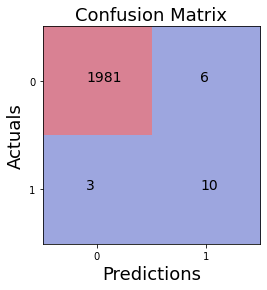

In [168]:
cc_cm = ConfusionMatrix(modelcc, testcc)
cc_cm.fit()
cc_cm.print_metrics()
cc_cm.plot_matrix()

In [72]:
# 7. Predict on titanic dataset - https://www.kaggle.com/competitions/titanic/data


array([[0.2021911 , 0.86663459],
       [0.26005507, 0.48487318]])

In [ ]:
[[]]